## Create a Corpus with Textacy

The Python `textacy` library builds on top of spaCy. Below we are going to create a corpus of texts by Tolkien fans using `textacy`. Then we'll use its built-in methods to do some analysis.

In [220]:
# Python imports
import textacy

# Import spaCy's English language model
en = textacy.load_spacy_lang('en_core_web_sm')

# Get the path to the file containing our data. In this case,
# the data and metadata are stored together in one JSON file.
records = textacy.io.read_json('data/records.json', lines=True)
print('Done!')

Done!


In [221]:
# We next want to create tuples containing our data and metadata.
# We do this by splitting the file using textacy's split_records function.
record_tuples = textacy.io.utils.split_records(records, 'text', itemwise=True)

# Now we're ready to build the corpus. This can take a few minutes.
corpus = textacy.Corpus(textacy.load_spacy_lang('en_core_web_sm'), data=record_tuples)
corpus

Corpus(22 docs, 115388 tokens)

In [222]:
# We can get some quick statistics from the corpus
print('Number of documents: ' + str(corpus.n_docs))
print('Number of sentences: ' + str(corpus.n_sents))
print('Number of tokens: ' + str(corpus.n_tokens))

# Or preview a specific document
corpus[9]._.preview

Number of documents: 22
Number of sentences: 7310
Number of tokens: 115388


'Doc(8521 tokens: ""Excuse me?"  Maranwë, Chief Maia to Námo, Lord...")'

Now that we have a corpus, let's do some magic. `textacy` has some built in functions to count word vectors (lists of word counts for each text). With this information, it can make a document-term matrix showing the vectors for each document. We could view this matrix, but it is not very meaningful since it is just a bunch of numbers. So for now, let's just run it. `textacy` gives us a number of options which you can see in the `Vectorizer()` function. All you need to know is that we are running this with some settings that try to account for texts of different lengths, and we are ignoring extremely rare or frequent terms.

In [217]:
# Import the textacy vectorizer and matrix module
import textacy.vsm

# Vectorize our corpus
vectorizer = textacy.vsm.Vectorizer(
     tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2",
     min_df=2, max_df=0.95)

# Create the document-term matrix
doc_term_matrix = vectorizer.fit_transform(
     (doc._.to_terms_list(ngrams=1, entities=True, as_strings=True)
      for doc in corpus))
print('Done!')

Now that we have a document-term matrix, what can we do with it? Lots of things. But to keep things simple, let's employ a method of analysis called "topic modelling", which is built-in to `textacy`. Topic modelling makes three assumptions:

1. All texts are made up of a finite set of themes/subjects/discources called "topics".
2. These topics can be represented by lists of terms organised by the probability of each term occurring in the topic.
3. An algorithm can be applied to a corpus of texts to reverse engineer the topics that make up those texts.

There are many types of topic modelling algorithms. Two popuular ones are Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF).

We feed our document-term matrix into a topic modelling engine with our desired settings, including the method and the number of topics we want to generate. We get a document-**topic** matrix back. Again, this is all numbers, but we can do some fancy magic in two lines to output a list of topics and the top (most "probable") terms in each topic. We'll do this below. 

In [224]:
# Import the topic modelling module
import textacy.tm  # note the import

# Choose our modelling method and number of topics
method = 'lda' # Latent Dirichlet Allocation
# method = 'nmf' # Non-Negative Matrix Factorization
model = textacy.tm.TopicModel(method, n_topics=10)

# Produce the model and the document-topic matrix
model.fit(doc_term_matrix)
doc_topic_matrix = model.transform(doc_term_matrix)

# Show a list of the top terms in each topic
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : Ada   Ivoreth   Elrohir   arm   stallion   think   Glorfindel   Legolas   tell   obvious
topic 1 : service   sorry   grunt   Glorfindel   actually   friendship   come   especially   free   pant
topic 2 : Faramir   brave   Aragorn   counter   renew   ball   throne   tooth   paperwork   proudly
topic 3 : Elrond   letter   talk   Lord   interested   love   office   nice   old   bond
topic 4 : tree   battle   distant   host   aid   Mountain   axe   act   fend   hope
topic 5 : Elrond   hand   palm   diminish   hesitation   velvet   evaporate   considerable   weight   pouch
topic 6 : hole   reckon   letter   ten   pleasant   observation   snipe   grunt   Celeborn   quiet
topic 7 : Legolas   Gimli   Thranduil   Aragorn   say   look   time   come   elf   like
topic 8 : energy   rage   celebration   realm   tightly   obvious   arena   young   belt   Rohan
topic 9 : Ivoreth   Námo   shroud   quick   generous   breaking   step   master   observation   simple


`textacy` provides a useful visualisation showing the weights of each term in each topic. If you used LDA, you probably got a bad model in which only one topic is very distinguishable. This is partially a result of our small data set. But try NMF and see if you get something better.

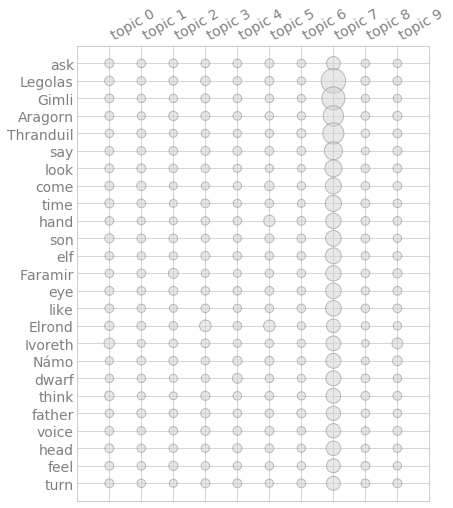

In [225]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, topics=-1, n_terms=25, sort_terms_by="seriation")